In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow.keras import layers
from keras.callbacks import History
import matplotlib.pyplot as plt
import os
from tensorflow.keras.optimizers import Adam
from plain_neural_network import*
from matplotlib import cm


2023-12-17 13:40:26.073381: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-17 13:40:27.565106: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import glob
import random
input_dir = "/albedo/work/user/ssunar/for_paper/segmentation_masks/Gulfstream/"
input_file_paths = sorted(glob.glob(input_dir+'*.nc'))
print(len(input_file_paths))
random_num = random.randint(0,len(input_file_paths))

data = xr.open_mfdataset(input_file_paths[:],combine = 'nested', concat_dim="TIME").astype('float32')
X = data.ssh.to_numpy()
test_y = data.seg_mask.to_numpy()
X = X[:, :, :]
test_y = test_y[:, :, :]

X[X>1000] = 0

X.shape
test_y.shape

130


(3958, 600, 300)

In [4]:
data_long = data.LONGITUDE
data_lat = data.LATITUDE
xx, yy = np.meshgrid(data_long, data_lat)

In [5]:
img_size = (600, 300)
num_classes = 3
# input_dir_X = "/albedo/home/ssunar/CNN_eddy_detection/for_paper/interpolation/test"
weight_path = "/albedo/work/user/ssunar/for_paper/unet_trained/Gulfstream/train/weights.h5"
preds_y = using_model_(img_size, num_classes, X, weight_path)
print(preds_y.shape)
np.save('/albedo/work/user/ssunar/for_paper/segmentation_masks/Gulfstream_pred/pred_data.npy', preds_y)

2023-12-17 13:43:21.714391: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


124/124 [==============================] - 367s 3s/step
(3958, 600, 300)


In [17]:
img_size = (600, 296)
num_classes = 3
weight_path_south_atlantic = "/albedo/work/user/ssunar/for_paper/unet_trained/south_atlantic/train/weights.h5"
preds_y_south_atlantic = using_model_(img_size, num_classes, X, weight_path_south_atlantic)
print(preds_y_south_atlantic.shape)

1/1 [==============================] - 3s 3s/step
(30, 600, 296)


In [5]:
data_y = test_y
unique, counts = np.unique(data_y, return_counts=True)
print(dict(zip(unique, counts)))

freq = [np.sum(counts)/j for j in counts]
weightsSeg = [f/np.sum(freq) for f in freq]
print(weightsSeg)
weight_train = weightsSeg

{0.0: 4666922, 1.0: 485422, 2.0: 353256}
[0.041972161757744396, 0.4035268386986498, 0.5545009995436058]


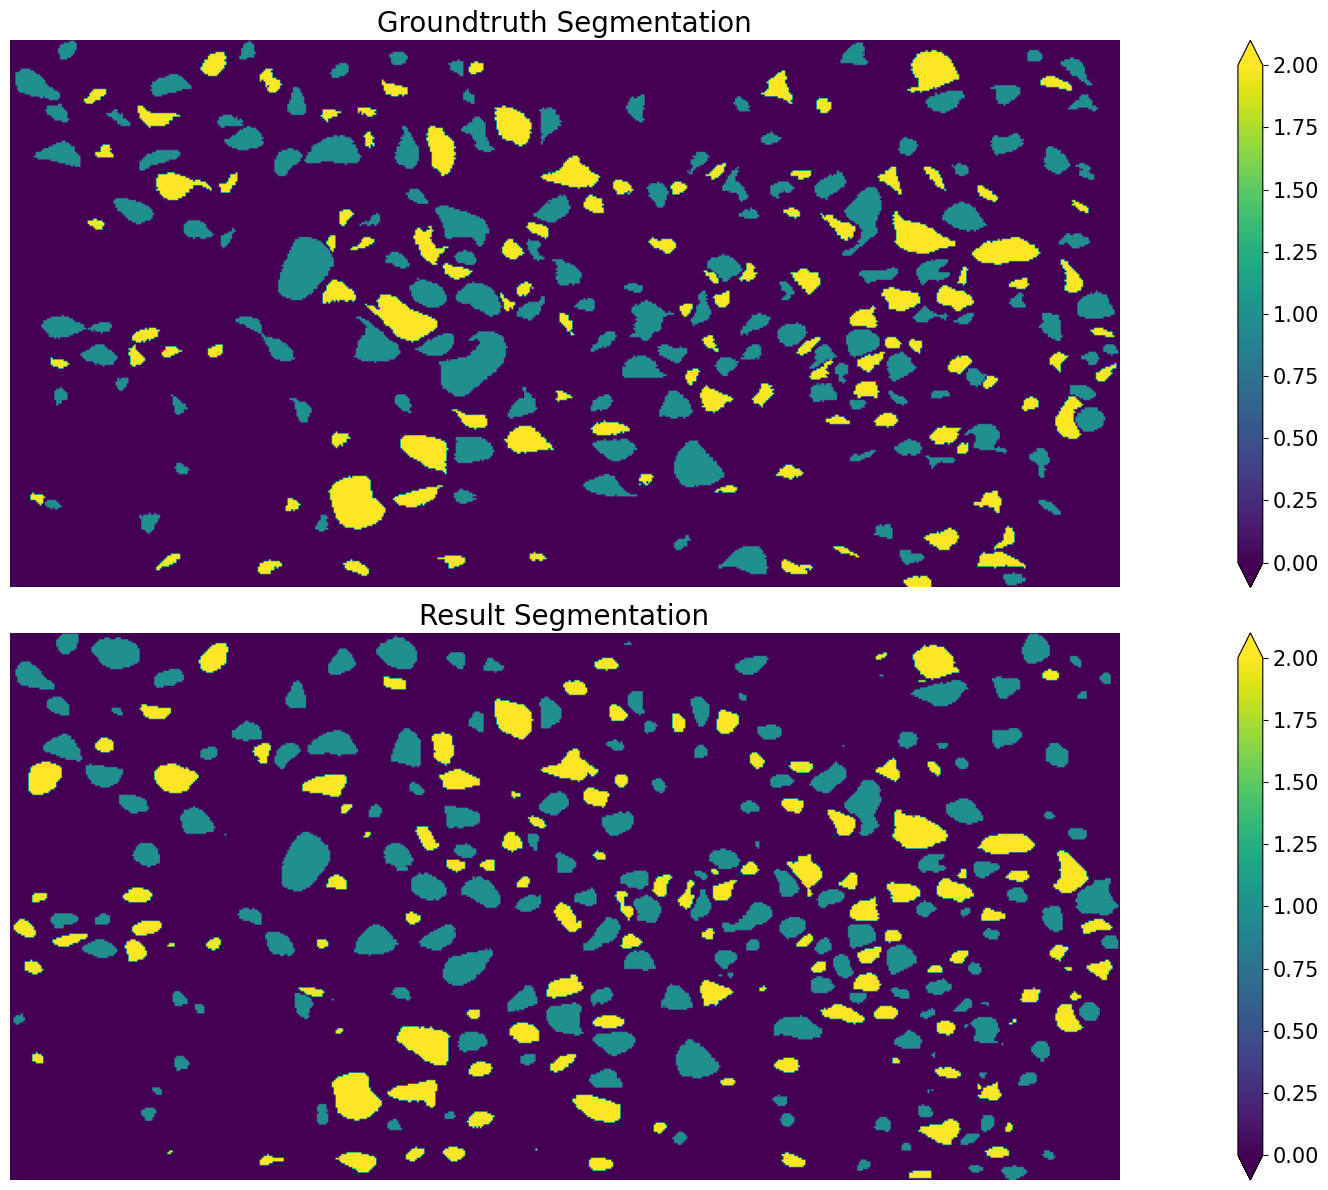

In [6]:
dir_path = "/albedo/work/user/ssunar/for_paper/unet_trained/Gulfstream/"

# Create a figure with two subplots stacked on top of each other
fig, axs = plt.subplots(2, 1, figsize=(30, 12))

# Plot groundtruth segmentation
im0 = axs[0].imshow(test_y[20].T, cmap='viridis')
cbar0 = plt.colorbar(im0, ax=axs[0], extend='both', fraction=0.042, pad=0.04)
cbar0.ax.tick_params(labelsize=15)
cbar0.ax.yaxis.offsetText.set(size=15)
axs[0].axis('off')
axs[0].set_title('Groundtruth Segmentation', fontsize=20)

# Plot result segmentation
im1 = axs[1].imshow(preds_y[20].T, cmap='viridis')
cbar1 = plt.colorbar(im1, ax=axs[1], extend='both', fraction=0.042, pad=0.04)
cbar1.ax.tick_params(labelsize=15)
cbar1.ax.yaxis.offsetText.set(size=15)
axs[1].axis('off')
axs[1].set_title('Result Segmentation', fontsize=20)

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.5)

# Save the combined figure
plt.tight_layout()
plt.savefig(dir_path + "comparison_840_480.png", dpi=100)

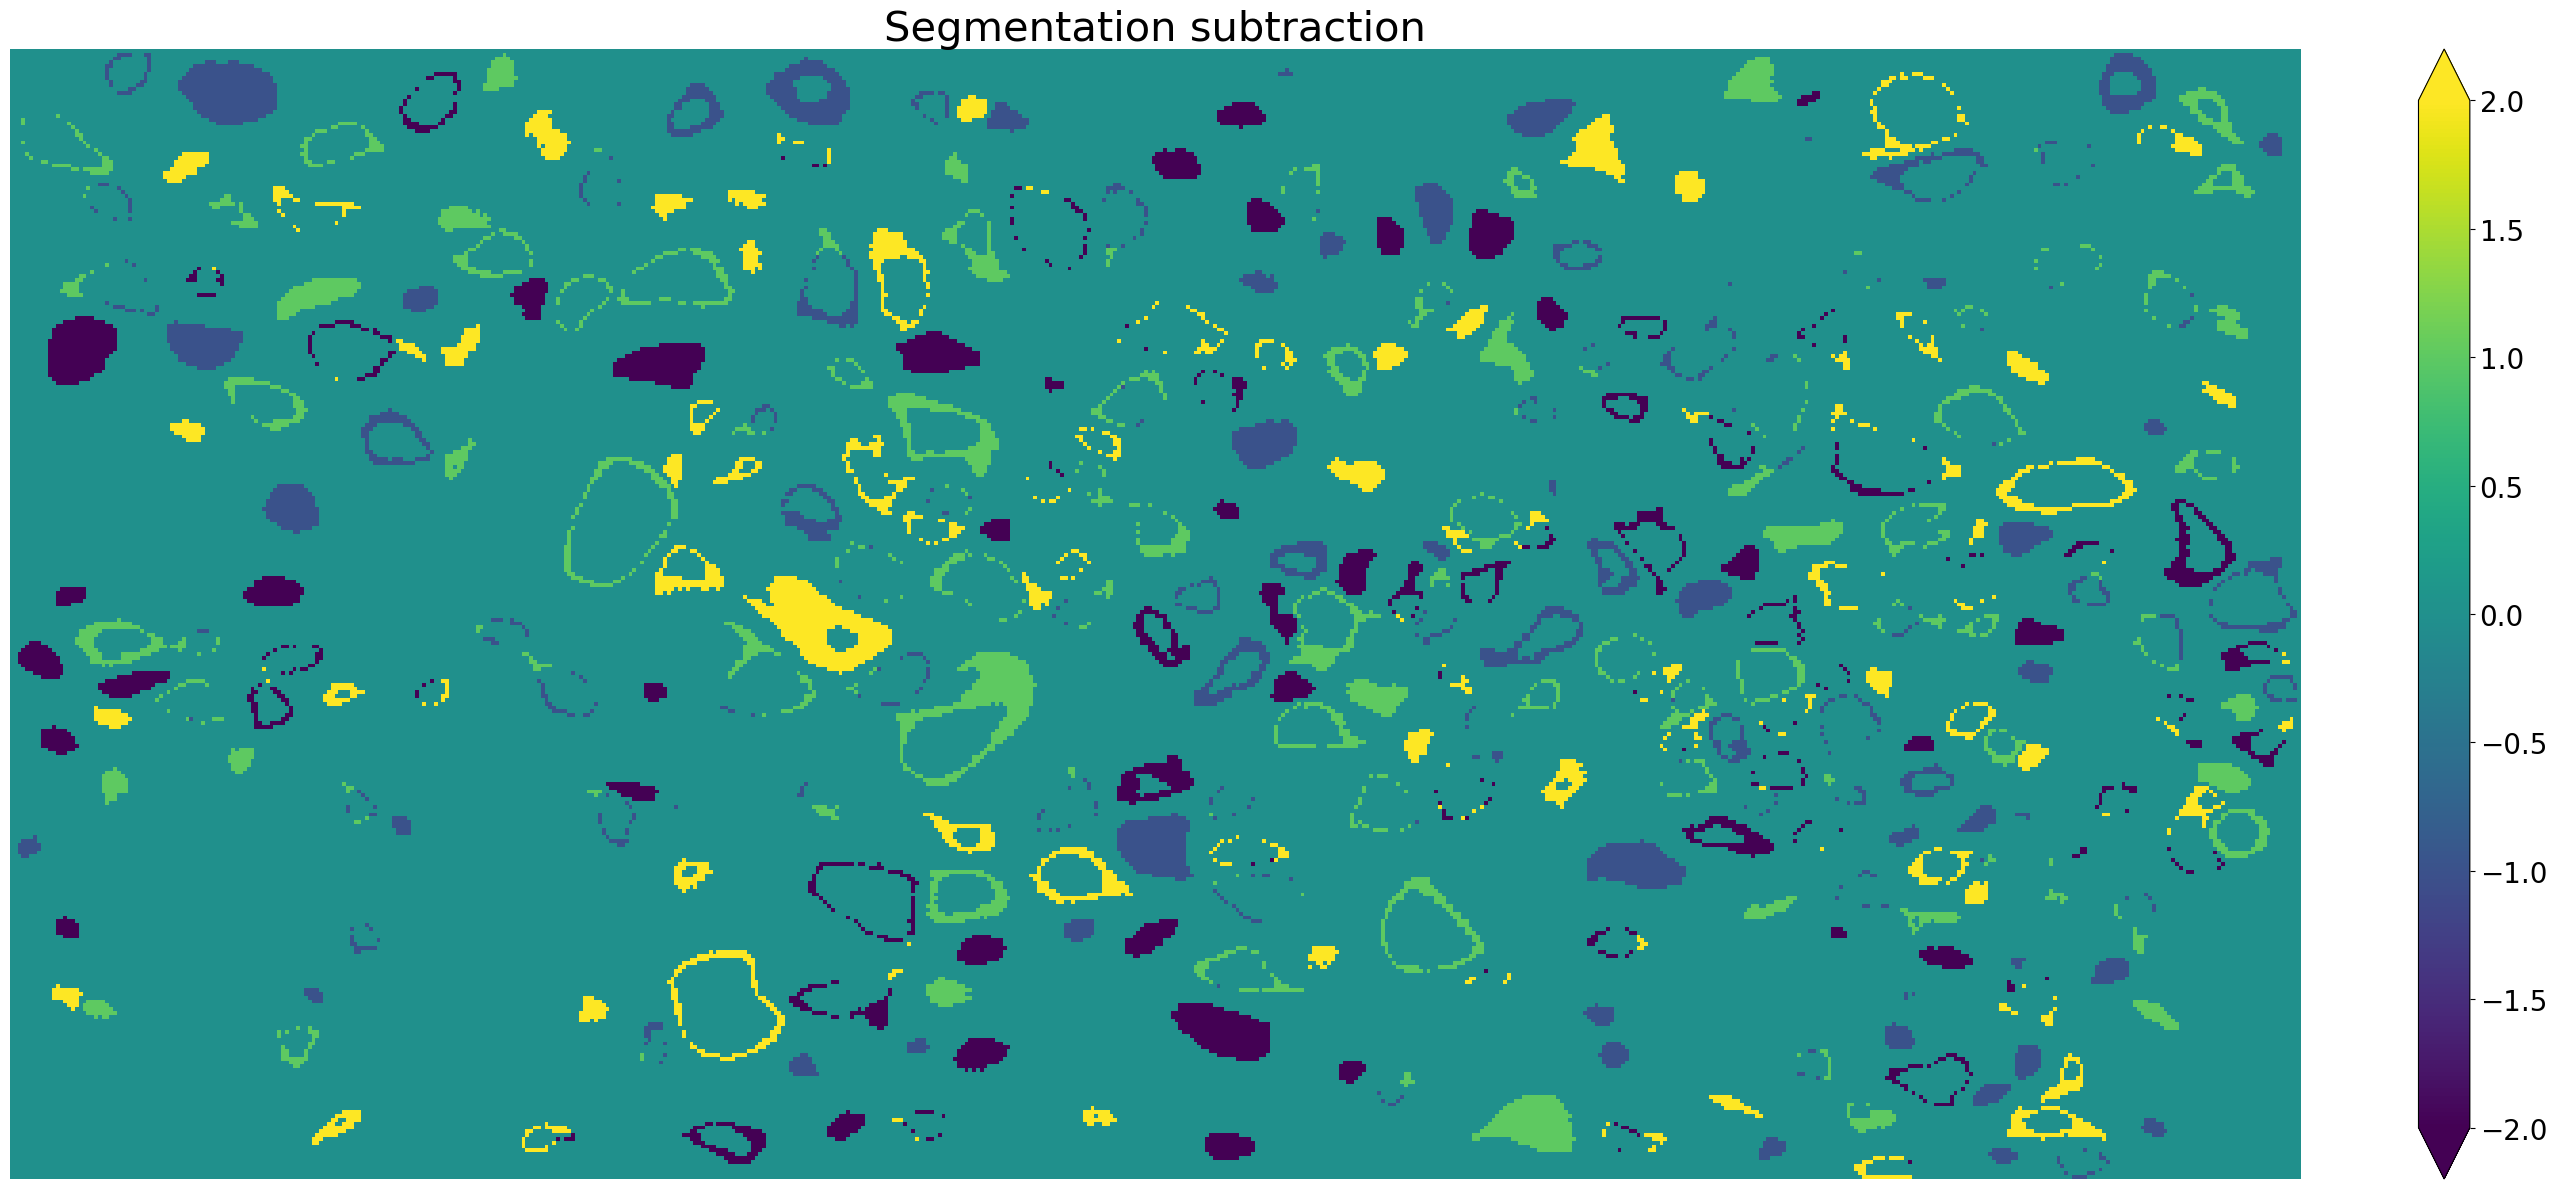

In [7]:
plt.figure(figsize=(30, 12))
plt.imshow(test_y[20].T-preds_y[20].T, cmap='viridis')
cbar = plt.colorbar(extend='both', fraction=0.042, pad=0.04)
cbar.ax.tick_params(labelsize=20)
cbar.ax.yaxis.offsetText.set(size=20)
plt.axis('off')
plt.title('Segmentation subtraction', fontsize=30)
plt.tight_layout()
plt.savefig(dir_path + "segmentation_subtraction.png", dpi=100)

In [8]:
X.shape

(31, 600, 296)

In [9]:
X = np.pad(X, ((0, 0), (0, 0), (0, 4)), mode='constant')
test_y = np.pad(test_y, ((0, 0), (0, 0), (0, 4)), mode='constant')
preds_y = np.pad(preds_y, ((0, 0), (0, 0), (0, 4)), mode='constant')

/tmp/ipykernel_519986/3717592748.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axs[0].pcolormesh(data_long, data_lat, np.transpose(X[15,:,:]), cmap=cm.seismic, vmin=-1, vmax=1)
/tmp/ipykernel_519986/3717592748.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axs[1].pcolormesh(data_long, data_lat, np.transpose(X[15,:,:]), cmap=cm.seismic, vmin=-1, vmax=1)


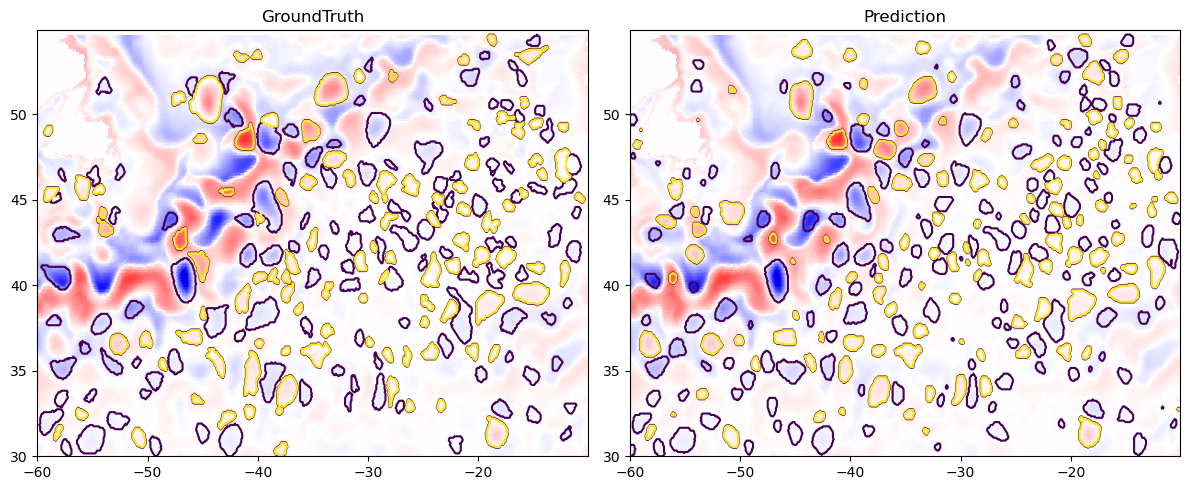

In [10]:
dir_path = "/albedo/work/user/ssunar/for_paper/unet_trained/south_atlantic/train"
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].pcolormesh(data_long, data_lat, np.transpose(X[15,:,:]), cmap=cm.seismic, vmin=-1, vmax=1)
axs[0].contour(xx, yy, np.transpose(test_y[15,:,:]), levels=[0,1])
axs[0].set_title('GroundTruth')

axs[1].pcolormesh(data_long, data_lat, np.transpose(X[15,:,:]), cmap=cm.seismic, vmin=-1, vmax=1)
axs[1].contour(xx, yy, np.transpose(preds_y[15,:,:]), levels=[0,1])
axs[1].set_title('Prediction')

plt.tight_layout()
plt.savefig(dir_path + "comparison_plots.png", dpi = 300)
plt.show()

In [ ]:
preds_y_south_atlantic = np.pad(preds_y_south_atlantic, ((0, 0), (0, 0), (0, 4)), mode='constant')

In [ ]:
# Prediction of Gulfstream data using Model trained in South Atlantic region
dir_path = "/albedo/work/user/ssunar/for_paper/unet_trained/comparison/"
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].pcolormesh(data_long, data_lat, np.transpose(X[15,:,:]), cmap=cm.seismic, vmin=-1, vmax=1)
axs[0].contour(xx, yy, np.transpose(test_y[15,:,:]), levels=[0,1])
axs[0].set_title('GroundTruth')

axs[1].pcolormesh(data_long, data_lat, np.transpose(X[15,:,:]), cmap=cm.seismic, vmin=-1, vmax=1)
axs[1].contour(xx, yy, np.transpose(preds_y_south_atlantic[15,:,:]), levels=[0,1])
axs[1].set_title('Prediction')

plt.tight_layout()
plt.savefig(dir_path + "comparison_plots.png", dpi = 300)
plt.show()